In [1]:
from ib_insync import *
util.startLoop()  # uncomment this line when in a notebook
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from datetime import datetime

ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

## Get stock price

In [2]:
contract = Stock("AAPL", exchange="NYSE")

In [3]:
historical_bars = ib.reqHistoricalData(
    contract,
    endDateTime = "",
    durationStr = "1 M",
    barSizeSetting = "1 day",
    whatToShow = "MIDPOINT",
    useRTH = False,
    formatDate = 1
)

df = util.df(historical_bars)
print(df)

          date    open    high     low   close  volume  average  barCount
0   2024-01-17  181.33  186.12  176.83  182.63    -1.0     -1.0        -1
1   2024-01-18  186.17  190.94  181.57  188.92    -1.0     -1.0        -1
2   2024-01-19  189.20  194.03  184.08  191.59    -1.0     -1.0        -1
3   2024-01-22  191.98  197.10  191.97  193.90    -1.0     -1.0        -1
4   2024-01-23  194.64  195.78  193.81  195.12    -1.0     -1.0        -1
5   2024-01-24  195.38  200.26  191.03  194.53    -1.0     -1.0        -1
6   2024-01-25  194.28  199.74  190.54  194.22    -1.0     -1.0        -1
7   2024-01-26  194.24  198.98  189.37  192.40    -1.0     -1.0        -1
8   2024-01-29  192.03  194.45  187.23  191.78    -1.0     -1.0        -1
9   2024-01-30  190.56  195.36  185.78  187.99    -1.0     -1.0        -1
10  2024-01-31  187.14  191.47  182.44  184.40    -1.0     -1.0        -1
11  2024-02-01  185.32  190.08  179.59  186.89    -1.0     -1.0        -1
12  2024-02-02  180.93  187.61  175.09

In [4]:
historical_bars = ib.reqHistoricalData(1, contract, "", "1 D", "1 day", "EPS", 1, 1, False, [])

AttributeError: 'int' object has no attribute 'includeExpired'

## Get fundamentals

In [5]:
fundamentals = ib.reqFundamentalData(contract, reportType='RESC') # data comes in xml format
root = ET.fromstring(fundamentals)

tree = ET.ElementTree(root)
tree.write('output.xml', encoding='utf-8', xml_declaration=True)

# with open('output.xml', 'w') as f:
#     f.write(soup.prettify())
# fundamentals_snapshot = ib.reqFundamentalData(contract, reportType='ReportSnapshot') # only the latest year?

In [6]:
root.findall('FYPeriod')

[]

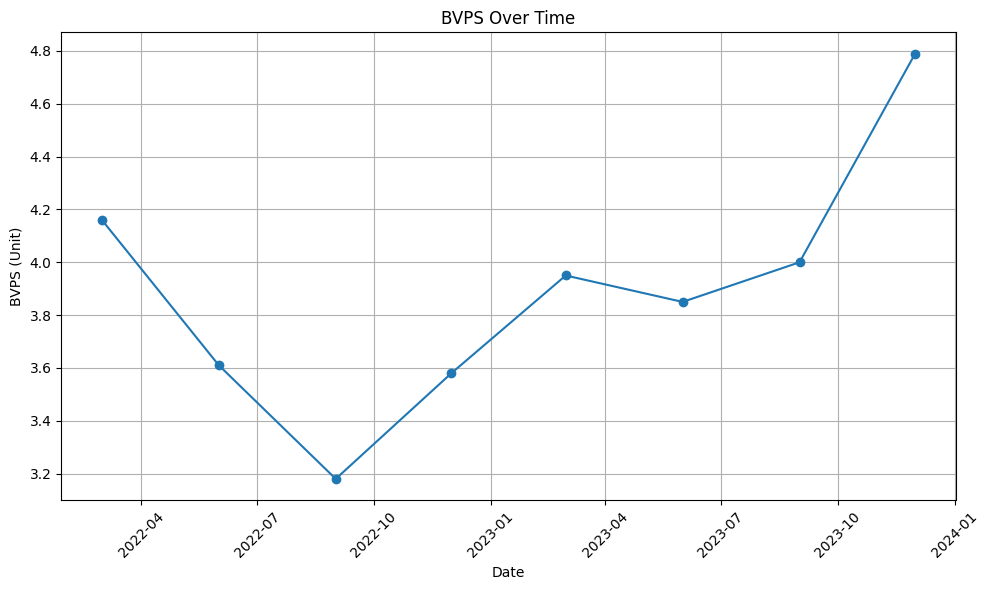

In [10]:
resolution = 'Q' # Q (quarterly) or A (annual)

# Initialize dictionaries to store EBIT values by month
dates = []
values = []

assert resolution == 'Q' or 'A', f"{resolution=} is not supported. Please choose either 'Q' or 'A'"
# Iterate through FYActual elements
for fy_actual in root.findall('.//FYActual[@type="BVPS"]'):
    # Iterate through FYPeriod elements
    for fy_period in fy_actual.findall('FYPeriod'):
        if fy_period.get('periodType') == resolution:
            end_year = int(fy_period.get('fYear'))
            end_month = int(fy_period.get('endMonth'))
            values.append(float(fy_period.find('ActValue').text))
            date = datetime.strptime(f"{end_year}-{end_month}", "%Y-%m")
            dates.append(date)


# Sort the dates from old to recent
sorted_dates, sorted_values = zip(*sorted(zip(dates, values)))

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, sorted_values, marker='o', linestyle='-')
plt.title('BVPS Over Time')
plt.xlabel('Date')
plt.ylabel('BVPS (Unit)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()